In [1]:
import pandas as pd
import json
import numpy as np
import operator
import matplotlib.pyplot as plt
from collections import Counter
import os
import time
import pickle
import networkx as nx
import string
import matplotsoccer
pd.options.mode.chained_assignment = None  # default='warn'



zone_positions = {
    'R0': (100/6, 250/3*0.68),
    'R1': (100/6, 50 *0.68),
    'R2': (100/6, 50/3 *0.68),
    'R3': (50, 250/3 *0.68),
    'R4': (50, 50 *0.68),
    'R5': (50, 50/3 *0.68),
    'R6': (250/3, 250/3 *0.68),
    'R7': (250/3, 50 *0.68),
    'R8': (250/3, 50/3 *0.68),
}

ROOT = os.path.dirname(os.getcwd())
teams = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'teams.pkl.gz'))
players = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'players.pkl.gz'))
players['shortName'] = players['shortName'].apply(lambda s: ''.join([x for x in s if x.isalpha() or x in [' ', '.'] ]))
player_mapping = {row['wyId'] : row['shortName'] for i, row in players.iterrows()}

# Approach
First lets get the zonal information for the passes from last time

In [2]:
zonal_info_passing = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zonal_info_combined.pkl.gz'))
events = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'events_df.pkl.gz'))
matches = zonal_info_passing.index.get_level_values(0).unique()
zonal_info_passing

KeyboardInterrupt: 

In [ ]:
matchId = 2499719

#Get the time for the latest event in the first half for this match
end_first_half = events.loc[(events['matchId']==matchId)
                            &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


df = zonal_info_passing.loc[(zonal_info_passing.index.get_level_values(0)==matchId)]
df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
df['teamId'] = df.index.get_level_values(1)
#df = df[['playerId', 'positions', 'teamId', 'time']]


team1, team2 = df['teamId'].unique()
profile_team1 = df.loc[df['teamId'] == team1, :].sort_values(by='time').reset_index(drop=True)
profile_team2 = df.loc[df['teamId'] == team2, :].sort_values(by='time').reset_index(drop=True)



#Formatting these for the graphs
profile_team1 = profile_team1[['zone_origin', 'zone_destination']]
profile_team1 = profile_team1.loc[profile_team1['zone_origin'] != profile_team1['zone_destination']]
profile_team1 = profile_team1.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)

profile_team2 = profile_team2[['zone_origin', 'zone_destination']]
profile_team2 = profile_team2.loc[profile_team2['zone_origin'] != profile_team2['zone_destination']]
profile_team2 = profile_team2.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)

### Graph Visualization

In [ ]:
team1, team2 = teams.loc[teams['wyId']==team1,'name'].values[0], teams.loc[teams['wyId']==team2,'name'].values[0]

#team1
ax = matplotsoccer.field("green",figsize=10, show=False)
g = nx.DiGraph()
g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team1.iterrows()])
g = nx.relabel_nodes(g, {i: 'R{}'.format(i) for i in range(9)})
nx.draw(g, zone_positions, with_labels=True, font_weight='bold', node_color = 'y', 
        width=[g[u][v]['weight']/5 for u, v in g.edges()], ax=ax)
print (team1)
print ('centrality =', nx.global_reaching_centrality(g))
print ('density =', nx.density(g))
plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'zone_graph_ex1.png'))
plt.show()
print ('%s: mean ='%team1, profile_team1['weight'].mean()/profile_team1['weight'].sum()*100,
       '; std =', profile_team1['weight'].std()/profile_team1['weight'].sum()*100,
       '; count =', profile_team1['weight'].sum())

#team2
ax = matplotsoccer.field("green",figsize=10, show=False)
g = nx.DiGraph()
g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
g = nx.relabel_nodes(g, {i: 'R{}'.format(i) for i in range(9)})
nx.draw(g, zone_positions, with_labels=True, font_weight='bold', node_color = 'r',
        width=[g[u][v]['weight']/5 for u, v in g.edges()], ax=ax)
print ('\n\n\n', team2)
print ('centrality =', nx.global_reaching_centrality(g))
plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'zone_graph_ex2.png'))
print ('density =', nx.density(g))
plt.show()
print ('%s: mean ='%team1, profile_team2['weight'].mean()/profile_team2['weight'].sum()*100,
       '; std =', profile_team2['weight'].std()/profile_team2['weight'].sum()*100,
       '; count =', profile_team2['weight'].sum())

## What metrics can we derive from these?

### 1) Zonal Mean & Std()
A high std() will imply the coexistence of "hot" zones and "cold" zones on the pitch. A lower std() will imply a more uniform distribution of passes across the pitch

In [ ]:
p = pd.Series(dict(g.degree(weight='weight')))
display(p.mean())
display(p.std())

#### To Streamline

In [ ]:
n = len(matches)
network_stats = dict()

for i, matchId in enumerate(matches):
    if i % 50 == 0: print('{}/{}'.format(i, n))
        
    #Get the time for the latest event in the first half for this match
    end_first_half = events.loc[(events['matchId']==matchId)
                                &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


    df = zonal_info_passing.loc[(zonal_info_passing.index.get_level_values(0)==matchId)]
    df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
    df['teamId'] = df.index.get_level_values(1)
    #df = df[['playerId', 'positions', 'teamId', 'time']]


    team1, team2 = df['teamId'].unique()
    profile_team1 = df.loc[df['teamId'] == team1, :].sort_values(by='time').reset_index(drop=True)
    profile_team2 = df.loc[df['teamId'] == team2, :].sort_values(by='time').reset_index(drop=True)
    
    #Saving Stats as dict of dicts
    network_stats[matchId] = dict()
    network_stats[matchId][team1], network_stats[matchId][team2] = dict(), dict() 



    #Formatting these for the graphs
    profile_team1 = profile_team1[['zone_origin', 'zone_destination']]
    profile_team1 = profile_team1.loc[profile_team1['zone_origin'] != profile_team1['zone_destination']]
    profile_team1 = profile_team1.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)

    profile_team2 = profile_team2[['zone_origin', 'zone_destination']]
    profile_team2 = profile_team2.loc[profile_team2['zone_origin'] != profile_team2['zone_destination']]
    profile_team2 = profile_team2.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)
        
    g = nx.DiGraph()
    g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team1.iterrows()])
    df = pd.Series(dict(g.degree(weight='weight')), name='number_passes_invloved')
    network_stats[matchId][team1]['mean_passes_zone'] = df.mean()
    network_stats[matchId][team1]['std_passes_zone'] = df.std()
    
    g = nx.DiGraph()
    g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
    df = pd.Series(dict(g.degree(weight='weight')), name='number_passes_invloved')
    network_stats[matchId][team2]['mean_passes_zone'] = df.mean()
    network_stats[matchId][team2]['std_passes_zone'] = df.std()
    
    
network_stats = pd.DataFrame.from_dict({(i,j): network_stats[i][j] 
                           for i in network_stats.keys() 
                           for j in network_stats[i].keys()},
                       orient='index')
network_stats

In [ ]:
#network_stats.to_pickle(os.path.join(ROOT, 'intermediates', 'zonal_passing_networks_exploration.pkl.gz'))

### 2) What about key passing lanes?
As seen in the graph below, there is a key passing lane from R5 to R8. Is this consistent acorss all matches? If yes can we tactically exploit this?

In [ ]:
matchId = 2499719

#Get the time for the latest event in the first half for this match
end_first_half = events.loc[(events['matchId']==matchId)
                            &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


df = zonal_info_passing.loc[(zonal_info_passing.index.get_level_values(0)==matchId)]
df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
df['teamId'] = df.index.get_level_values(1)
#df = df[['playerId', 'positions', 'teamId', 'time']]


team1, team2 = df['teamId'].unique()
profile_team2 = df.loc[df['teamId'] == team2, :].sort_values(by='time').reset_index(drop=True)
profile_team2 = profile_team2[['zone_origin', 'zone_destination']]
profile_team2 = profile_team2.loc[profile_team2['zone_origin'] != profile_team2['zone_destination']]
profile_team2 = profile_team2.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)
#team2
ax = matplotsoccer.field("green",figsize=10, show=False)
g = nx.DiGraph()
g.add_edges_from([(row['zone_origin'], row['zone_destination'], {'weight':row['weight']}) for i, row in profile_team2.iterrows()])
g = nx.relabel_nodes(g, {i: 'R{}'.format(i) for i in range(9)})
nx.draw(g, zone_positions, with_labels=True, font_weight='bold', node_color = 'r',
        width=[g[u][v]['weight']/5 for u, v in g.edges()], ax=ax)
print ('\n\n\n', team2)
print ('centrality =', nx.global_reaching_centrality(g))
#print ('algebric connectivity =', nx.algebraic_connectivity(g))
print ('density =', nx.density(g))
plt.show()
print ('%s: mean ='%team1, profile_team2['weight'].mean()/profile_team2['weight'].sum()*100,
       '; std =', profile_team2['weight'].std()/profile_team2['weight'].sum()*100,
       '; count =', profile_team2['weight'].sum())

In [ ]:
profile_team2['p1'] = profile_team2[['zone_origin', 'zone_destination']].min(axis=1)
profile_team2['p2'] = profile_team2[['zone_origin', 'zone_destination']].max(axis=1)
idx = pd.MultiIndex.from_tuples([(i, j) for i in range(9) for j in range(9) if i < j])
plt.figure()
(profile_team2[['p1', 'p2', 'weight']].groupby(by=['p1', 'p2']).sum()/profile_team2[['weight']].sum()).reindex(idx).plot(kind='bar', figsize=(15, 5))
plt.xlabel('Passing Lane', fontsize=14)
plt.ylabel('Relative Strength', fontsize=14)

A plot like this can tell us the relative strength of certain passing lanes.   
**Question**: Do teams show the same prominent passing lanes across all matches?  
**To-do**: Streamline this for all teams, all games

##### Streamlining

In [ ]:
n = len(matches)
idx = pd.MultiIndex.from_tuples([(i, j) for i in range(9) for j in range(9) if i < j])
passing_lane_stats = dict()

for i, matchId in enumerate(matches):
    profile_team1, profile_team2 = None, None
    
    if i % 50 == 0: print('{}/{}'.format(i, n))
        
    #Get the time for the latest event in the first half for this match
    end_first_half = events.loc[(events['matchId']==matchId)
                                &(events['matchPeriod']=='1H'), ['eventSec']].max().values[0]


    df = zonal_info_passing.loc[(zonal_info_passing.index.get_level_values(0)==matchId)]
    df.loc[:, 'time'] = (df['matchPeriod']=='2H')*end_first_half + df['eventSec']
    df['teamId'] = df.index.get_level_values(1)
    #df = df[['playerId', 'positions', 'teamId', 'time']]


    team1, team2 = df['teamId'].unique()
    profile_team1 = df.loc[df['teamId'] == team1, :].sort_values(by='time').reset_index(drop=True)
    profile_team2 = df.loc[df['teamId'] == team2, :].sort_values(by='time').reset_index(drop=True)
    
    #Identifying passing lanes
    profile_team1 = profile_team1[['zone_origin', 'zone_destination']]
    profile_team1 = profile_team1.loc[profile_team1['zone_origin'] != profile_team1['zone_destination']]
    profile_team1 = profile_team1.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)
    profile_team1['p1'] = profile_team1[['zone_origin', 'zone_destination']].min(axis=1)
    profile_team1['p2'] = profile_team1[['zone_origin', 'zone_destination']].max(axis=1)    
    profile_team1 = profile_team1[['p1', 'p2', 'weight']]
    profile_team1 = profile_team1[['p1', 'p2', 'weight']].groupby(by=['p1', 'p2']).sum()/profile_team1[['weight']].sum()
    
    profile_team2 = profile_team2[['zone_origin', 'zone_destination']]
    profile_team2 = profile_team2.loc[profile_team2['zone_origin'] != profile_team2['zone_destination']]
    profile_team2 = profile_team2.groupby(['zone_origin','zone_destination']).size().to_frame('weight').reset_index().astype(int)
    profile_team2['p1'] = profile_team2[['zone_origin', 'zone_destination']].min(axis=1)
    profile_team2['p2'] = profile_team2[['zone_origin', 'zone_destination']].max(axis=1)    
    profile_team2 = profile_team2[['p1', 'p2', 'weight']]
    profile_team2 = profile_team2[['p1', 'p2', 'weight']].groupby(by=['p1', 'p2']).sum()/profile_team2[['weight']].sum()
    
    
    #Saving Stats
    passing_lane_stats[matchId] = dict()
    passing_lane_stats[matchId][team1], passing_lane_stats[matchId][team2] = dict(), dict()
    passing_lane_stats[matchId][team1] = profile_team1
    passing_lane_stats[matchId][team2] = profile_team2

    
    #make directories
    if not os.path.exists(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team1))):
        os.makedirs(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team1)))
        
    if not os.path.exists(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team2))):
        os.makedirs(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team2)))
    
    #Plotting & Saving
    plt.figure()
    profile_team1.reindex(idx).plot(kind='bar', figsize=(15, 5))
    plt.xlabel('Passing Lane', fontsize=12)
    plt.ylabel('Relative Strength', fontsize=12)
    plt.title('Match: {} | Team: {}'.format(matchId, team1))
    plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team1), '{}.png'.format(matchId)))
    plt.close()
    
    plt.figure()
    profile_team2.reindex(idx).plot(kind='bar', figsize=(15, 5))
    plt.xlabel('Passing Lane', fontsize=12)
    plt.ylabel('Relative Strength', fontsize=12)
    plt.title('Match: {} | Team: {}'.format(matchId, team2))
    plt.savefig(os.path.join(ROOT, 'figures', 'passing_lane_study_nov_13', 'lane_distributions', str(team2), '{}.png'.format(matchId)))
    plt.close('all')
    

In [ ]:
d = dict()
for k in passing_lane_stats:
    d[k]=pd.concat(passing_lane_stats[k])
    
d = pd.concat(d)
d

In [ ]:
d.to_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info.pkl.gz'))

In [ ]:
d = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info.pkl.gz'))
d = d.unstack(level=['p1', 'p2']).droplevel(0, axis=1)
d.index = d.index.rename(['matchId', 'teamId'])
d.columns = d.columns.rename(['OriginZone', 'DestinationZone'])
d

These are 36 more features for each team, each match

### Zonal Graph Performance

In [3]:
df = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'player_passing_networks_exploration.pkl.gz'))
df2 = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zonal_passing_networks_exploration.pkl.gz'))
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
df.index = df.index.rename(['matchId', 'teamId'])

df = pd.concat([df, df2], axis=1)
display(df)

df.iloc[:, 1:] = df.iloc[:, 1:].divide(df['w'],axis=0)

df = df.mean(level=1).sort_index()
df = pd.concat([df, performance], axis=1)

w  mean_passes_players  std_passes_players  \
matchId teamId                                                   
2499719 1609    606.0            84.285714           59.311989   
        1631    230.0            30.285714           16.559583   
2499720 1625    754.0           105.428571           73.886310   
        1651    184.0            24.428571           14.345808   
2499721 1610    516.0            77.230769           48.071395   
...               ...                  ...                 ...   
2576336 3315    337.0            46.571429           24.453140   
2576337 3164    446.0            66.615385           39.434626   
        3204    363.0            53.538462           23.564151   
2576338 3185    338.0            46.571429           18.756391   
        3193    532.0            73.714286           35.497407   

                mean_passes_zone  std_passes_zone  
matchId teamId                                     
2499719 1609           89.333333        34.939233  
        1631           31.111111        10.178954  
2499720 1625          104.000000        67.673850  
        1651           26.222222        10.883218  
2499721 1610           75.333333        20.850659  
...                          ...              ...  
2576336 3315           41.777778         8.728943  
2576337 3164           63.333333        27.399818  
        3204           42.888889        16.914819  
2576338 3185           44.222222        14.584048  
        3193           64.000000        29.176189  

[3652 rows x 5 columns]

In [4]:
df

,w,mean_passes_players,std_passes_players,mean_passes_zone,std_passes_zone,name,city,area.name,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
674,413.789474,0.140712,0.088340,0.137419,0.054103,Valencia,Valencia,Spain,413.789474,11.000000,1.421053,73
675,581.078947,0.142033,0.078846,0.128619,0.045808,Real Madrid,Madrid,Spain,581.078947,16.605263,2.131579,76
676,612.105263,0.140638,0.078046,0.130913,0.054780,Barcelona,Barcelona,Spain,612.105263,13.210526,2.289474,93
677,382.605263,0.139624,0.076254,0.130934,0.044505,Deportivo La Coru\u00f1a,A Coru\u00f1a,Spain,382.605263,10.657895,0.921053,29
678,395.315789,0.140148,0.075199,0.138273,0.053388,Athletic Club,Bilbao,Spain,395.315789,9.921053,0.842105,43
...,...,...,...,...,...,...,...,...,...,...,...,...
3795,360.605263,0.137623,0.075303,0.127538,0.042832,Troyes,Troyes,France,360.605263,8.578947,0.710526,33
3799,379.105263,0.139537,0.080479,0.128009,0.048654,Angers,Angers,France,379.105263,10.736842,0.947368,43
3804,390.131579,0.139629,0.076787,0.136396,0.049637,Dijon,Dijon,France,390.131579,10.368421,1.236842,46
10531,390.578947,0.139775,0.079595,0.134895,0.053079,Swansea City,Swansea,England,390.578947,8.000000,0.684211,33


<Figure size 1080x360 with 0 Axes>

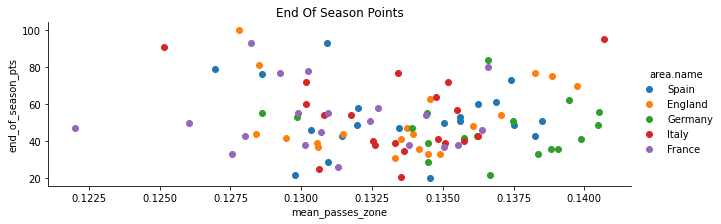

<Figure size 1080x360 with 0 Axes>

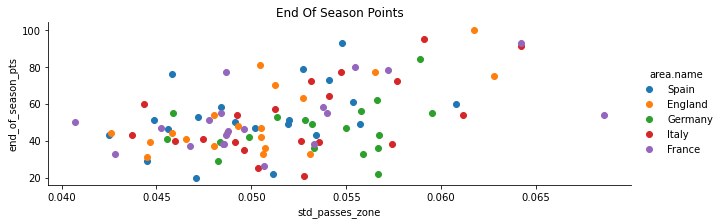

In [5]:
import seaborn
from matplotlib import pyplot 
#from ggplot import *

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'mean_passes_zone', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points')
plt.savefig('../figures/9_zone_network/mean_vs_avg_goals_norm.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 5))
fg = seaborn.FacetGrid(data=df, hue='area.name', hue_order=df['area.name'].unique(), aspect=3)
fg.map(pyplot.scatter, 'std_passes_zone', 'end_of_season_pts').add_legend()
plt.title('End Of Season Points')
plt.savefig('../figures/9_zone_network/std_vs_avg_goals_norm.png', bbox_inches='tight')
plt.show()

In [6]:
df.corr()

,w,mean_passes_players,std_passes_players,mean_passes_zone,std_passes_zone,avg_pass_per_game,avg_shots_per_game,avg_goals_per_game,end_of_season_pts
w,1.000000,0.217785,0.589938,-0.140192,0.638778,1.000000,0.803065,0.812468,0.763279
mean_passes_players,0.217785,1.000000,0.117718,0.003642,0.223724,0.217785,0.153953,0.187259,0.186572
std_passes_players,0.589938,0.117718,1.000000,0.034503,0.542965,0.589938,0.434198,0.427707,0.502012
mean_passes_zone,-0.140192,0.003642,0.034503,1.000000,0.232734,-0.140192,-0.068123,-0.048375,-0.086291
std_passes_zone,0.638778,0.223724,0.542965,0.232734,1.000000,0.638778,0.343656,0.500133,0.470776
avg_pass_per_game,1.000000,0.217785,0.589938,-0.140192,0.638778,1.000000,0.803065,0.812468,0.763279
avg_shots_per_game,0.803065,0.153953,0.434198,-0.068123,0.343656,0.803065,1.000000,0.774971,0.719890
avg_goals_per_game,0.812468,0.187259,0.427707,-0.048375,0.500133,0.812468,0.774971,1.000000,0.873299
end_of_season_pts,0.763279,0.186572,0.502012,-0.086291,0.470776,0.763279,0.719890,0.873299,1.000000
